# さまざまな意見についての Vader 感情分析

# はじめに

東京都知事選が終わりましたが、候補者に対して賛否両論さまざまな意見が上がっています。今回、収取した意見について Vaderを用いた Sentiment 解析を行い、発言者をクラス分けできるかやってみました。

VADER (Valence Aware Dictionary and sEntiment Reasoner) 感情分析は、ソーシャル メディアのテキストで表現された感情を分析するために設計された、語彙とルールに基づく感情分析ツールです。トレーニング済みなので、少ない数のデータに対しても学習無しで解析できます。

# 使用ライブラリ

In [1]:
!pip install --upgrade googletrans==3.1.0a0

import pandas as pd
import matplotlib.pyplot as plt
from googletrans import Translator
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.cluster import KMeans, AgglomerativeClustering

  Preparing metadata (setup.py) ... - \ | done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.9 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16352 sha256=c365613070f73cff06a5f9e5e9bcc87d07804fb460604c49921236bfc1f5ea1d
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# データ収集

I候補に対する意見をgeminiに問い合わせ収集しました。
発言者の苗字は略します。


In [2]:
japanese_sentences = [
    ("Shinjiro","彼のようなバイタリティ溢れる人物が都知事になれば、東京は大きく変わるだろう。彼に期待している。"),
    ("Ryuuki","彼は、自由な発想を持つ政治家だ。彼の今後の活躍が楽しみだ。"),
    ("Mitsuru","彼の発言は、炎上覚悟で本音を言っているように聞こえる。政治家に必要な勇気だと思う。"),
    ("Ikkei","彼は、分かりやすい言葉で政治を語る政治家だ。彼は国民の支持を集めるだろう。"),
    ("Ikou","彼の公約は具体性がない。数字や財源の裏付けを示すべきだ。"),
    ("Naoki","彼は政策よりもパフォーマンスに力を入れているようだ。都知事として期待できない。"),
    ("Ichiro","彼は政治家としての経験が浅いため、都知事という大役を果たせるかどうか心配だ。"),
    ("Yukio","彼は行政経験や財政知識が不足している。彼は都知事として必要な能力を備えているのか疑問だ。"),
    ("Chiharu","彼は質問を遮ったり、答えなかったりするなど、傲慢な態度だった。"),
    ("Yuichiro","彼の発言は、多様性を尊重する社会の実現に向けた重要な議論を呼び起こすものだ。"),
    ("Ruri","彼はカリスマ性がある一方で、傲慢で独りよがりな面もある。政治家としてふさわしい人物かどうか判断が難しい。"),
    ("Soichiro","彼はカリスマ性だけで政治を運営することはできない。実績を積み重ねていくことが重要だ。"),
]


英語に翻訳するので、日本語は英訳し易いように少し手を加えました。

# VADER 解析



極性スコア: VADER は、テキストごとに 4 つの感情スコアを提供します。

肯定スコア (pos): 肯定的として分類されるテキストの割合。
ネガティブ スコア (neg): ネガティブとして分類されるテキストの割合。
ニュートラル スコア (neu): ニュートラルとして分類されるテキストの割合。
複合スコア (comp): すべてのレキシコン評価の合計を計算し、-1 (最もネガティブ) から +1 (最もポジティブ) の間で正規化された集計正規化スコア。

In [3]:
translator = Translator()
vader_analyzer = SentimentIntensityAnalyzer()

names=[]
ja=[]
en=[]
pos=[]
neu=[]
neg=[]
comp=[]
for name,sentence in japanese_sentences:
    translated_text = translator.translate(sentence, src='ja', dest='en').text
    score = vader_analyzer.polarity_scores(translated_text)
    names+=[name]
    ja+=[sentence]
    en+=[translated_text]
    pos+=[score['pos']]
    neu+=[score['neu']]
    neg+=[score['neg']]
    comp+=[score['compound']]

    print(f"Name: {name}")
    print(f"Original: {sentence}")
    print(f"Translated: {translated_text}")
    print(f"Sentiment Score: {score}")
    print()

Name: Shinjiro
Original: 彼のようなバイタリティ溢れる人物が都知事になれば、東京は大きく変わるだろう。彼に期待している。
Translated: If a person full of vitality like him were to become Tokyo's governor, Tokyo would change dramatically. I have high hopes for him.
Sentiment Score: {'neg': 0.0, 'neu': 0.703, 'pos': 0.297, 'compound': 0.765}

Name: Ryuuki
Original: 彼は、自由な発想を持つ政治家だ。彼の今後の活躍が楽しみだ。
Translated: He is a politician with free ideas. I'm looking forward to his future activities.
Sentiment Score: {'neg': 0.0, 'neu': 0.784, 'pos': 0.216, 'compound': 0.5106}

Name: Mitsuru
Original: 彼の発言は、炎上覚悟で本音を言っているように聞こえる。政治家に必要な勇気だと思う。
Translated: His statements sound like he's telling the truth with the intention of causing a firestorm. I think he has the courage that politicians need.
Sentiment Score: {'neg': 0.0, 'neu': 0.704, 'pos': 0.296, 'compound': 0.7906}

Name: Ikkei
Original: 彼は、分かりやすい言葉で政治を語る政治家だ。彼は国民の支持を集めるだろう。
Translated: He is a politician who speaks politics in easy-to-understand terms. He will gain the support of the people.
S

In [4]:
data=pd.DataFrame()
data['name']=names
data['ja']=ja
data['en']=en
data['positive']=pos
data['neutral']=neu
data['negative']=neg
data['comp']=comp
display(data)

name                                                 ja  \
0   Shinjiro    彼のようなバイタリティ溢れる人物が都知事になれば、東京は大きく変わるだろう。彼に期待している。   
1     Ryuuki                      彼は、自由な発想を持つ政治家だ。彼の今後の活躍が楽しみだ。   
2    Mitsuru          彼の発言は、炎上覚悟で本音を言っているように聞こえる。政治家に必要な勇気だと思う。   
3      Ikkei              彼は、分かりやすい言葉で政治を語る政治家だ。彼は国民の支持を集めるだろう。   
4       Ikou                       彼の公約は具体性がない。数字や財源の裏付けを示すべきだ。   
5      Naoki            彼は政策よりもパフォーマンスに力を入れているようだ。都知事として期待できない。   
6     Ichiro             彼は政治家としての経験が浅いため、都知事という大役を果たせるかどうか心配だ。   
7      Yukio       彼は行政経験や財政知識が不足している。彼は都知事として必要な能力を備えているのか疑問だ。   
8    Chiharu                    彼は質問を遮ったり、答えなかったりするなど、傲慢な態度だった。   
9   Yuichiro             彼の発言は、多様性を尊重する社会の実現に向けた重要な議論を呼び起こすものだ。   
10      Ruri  彼はカリスマ性がある一方で、傲慢で独りよがりな面もある。政治家としてふさわしい人物かどうか判...   
11  Soichiro         彼はカリスマ性だけで政治を運営することはできない。実績を積み重ねていくことが重要だ。   

                                                   en  positive  neutral  \
0   If a person full of vitality like him were to ...     0.297    0.703   
1   He is a politician with free ideas. I'm lookin...     0.216    0.784   
2   His statements sound like he's telling the tru...     0.296    0.704   
3   He is a politician who speaks politics in easy...     0.289    0.711   
4   His pledge is not concrete. It should be suppo...     0.150    0.850   
5   He seems to be more focused on performance tha...     0.145    0.855   
6   Since he has little experience as a politician...     0.176    0.824   
7   He lacks administrative experience and financi...     0.079    0.833   
8   He had an arrogant attitude, interrupting ques...     0.000    0.625   
9   His remarks spark important discussions toward...     0.375    0.625   
10  While he is charismatic, he can also be arroga...     0.000    0.778   
11  He cannot run politics with charisma alone. It...     0.087    0.817   

    negative    comp  
0      0.000  0.7650  
1      0.000  0.5106  
2      0.000  0.7906  
3      0.000  0.7269  
4      0.000  0.3182  
5      0.000  0.4391  
6      0.000  0.5719  
7      0.087 -0.0516  
8      0.375 -0.6597  
9      0.000  0.6124  
10     0.222 -0.6908  
11     0.096 -0.0516

# Agglomerativeクラスタリング

In [5]:
def doAgglomerative(X, nclust=2):
    model = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage = 'ward')
    clust_labels = model.fit_predict(X)
    return clust_labels

clust_labels = doAgglomerative(data.iloc[:,3:],5)
agglomerative = pd.DataFrame(clust_labels)
data.insert((data.shape[1]),'cluster',agglomerative)
display(data)
df=data

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


name                                                 ja  \
0   Shinjiro    彼のようなバイタリティ溢れる人物が都知事になれば、東京は大きく変わるだろう。彼に期待している。   
1     Ryuuki                      彼は、自由な発想を持つ政治家だ。彼の今後の活躍が楽しみだ。   
2    Mitsuru          彼の発言は、炎上覚悟で本音を言っているように聞こえる。政治家に必要な勇気だと思う。   
3      Ikkei              彼は、分かりやすい言葉で政治を語る政治家だ。彼は国民の支持を集めるだろう。   
4       Ikou                       彼の公約は具体性がない。数字や財源の裏付けを示すべきだ。   
5      Naoki            彼は政策よりもパフォーマンスに力を入れているようだ。都知事として期待できない。   
6     Ichiro             彼は政治家としての経験が浅いため、都知事という大役を果たせるかどうか心配だ。   
7      Yukio       彼は行政経験や財政知識が不足している。彼は都知事として必要な能力を備えているのか疑問だ。   
8    Chiharu                    彼は質問を遮ったり、答えなかったりするなど、傲慢な態度だった。   
9   Yuichiro             彼の発言は、多様性を尊重する社会の実現に向けた重要な議論を呼び起こすものだ。   
10      Ruri  彼はカリスマ性がある一方で、傲慢で独りよがりな面もある。政治家としてふさわしい人物かどうか判...   
11  Soichiro         彼はカリスマ性だけで政治を運営することはできない。実績を積み重ねていくことが重要だ。   

                                                   en  positive  neutral  \
0   If a person full of vitality like him were to ...     0.297    0.703   
1   He is a politician with free ideas. I'm lookin...     0.216    0.784   
2   His statements sound like he's telling the tru...     0.296    0.704   
3   He is a politician who speaks politics in easy...     0.289    0.711   
4   His pledge is not concrete. It should be suppo...     0.150    0.850   
5   He seems to be more focused on performance tha...     0.145    0.855   
6   Since he has little experience as a politician...     0.176    0.824   
7   He lacks administrative experience and financi...     0.079    0.833   
8   He had an arrogant attitude, interrupting ques...     0.000    0.625   
9   His remarks spark important discussions toward...     0.375    0.625   
10  While he is charismatic, he can also be arroga...     0.000    0.778   
11  He cannot run politics with charisma alone. It...     0.087    0.817   

    negative    comp  cluster  
0      0.000  0.7650        0  
1      0.000  0.5106        4  
2      0.000  0.7906        0  
3      0.000  0.7269        0  
4      0.000  0.3182        3  
5      0.000  0.4391        3  
6      0.000  0.5719        4  
7      0.087 -0.0516        2  
8      0.375 -0.6597        1  
9      0.000  0.6124        0  
10     0.222 -0.6908        1  
11     0.096 -0.0516        2

明確な肯定的な人、明確に否定的な人、それ以外に分けることを目的とした。nclust=3では上手くいかなかった。nclust=5にすることで、明確な肯定的な人、明確に否定的な人、のクラスターと取り出すことができた。

In [6]:
cluster = df.groupby('cluster')['name'].apply(list).reset_index()
print(cluster)

   cluster                                  name
0        0  [Shinjiro, Mitsuru, Ikkei, Yuichiro]
1        1                       [Chiharu, Ruri]
2        2                     [Yukio, Soichiro]
3        3                         [Ikou, Naoki]
4        4                      [Ryuuki, Ichiro]


## Compound Score (comp) と Neutral Score (neu):
テキストの感情の強さと中立的な要素のバランスを確認できます。

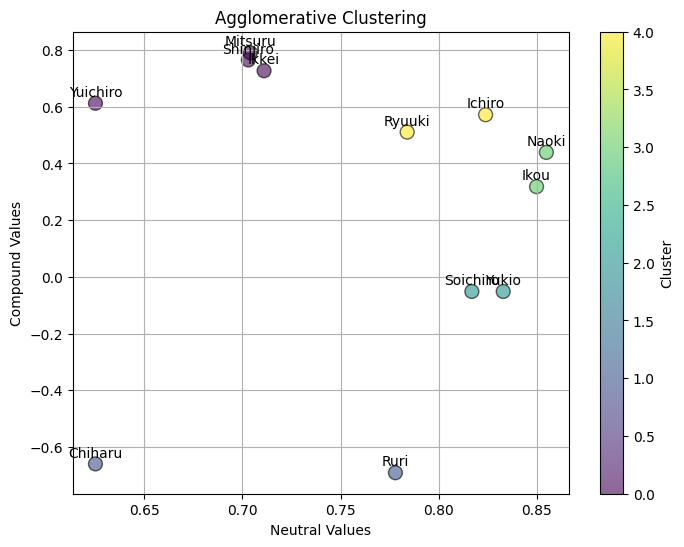

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(df['neutral'], df['comp'], c=df['cluster'], s=100, cmap='viridis', edgecolor='k', alpha=0.6)
for i, txt in enumerate(df['name']):
    plt.annotate(txt, (df['neutral'][i], df['comp'][i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel('Neutral Values')
plt.ylabel('Compound Values')
plt.title('Agglomerative Clustering')
plt.grid(True)
plt.colorbar(label='Cluster')
plt.show()

## Positive Score (pos) と Negative Score (neg):
テキストの肯定的な側面と否定的な側面を比較できます。

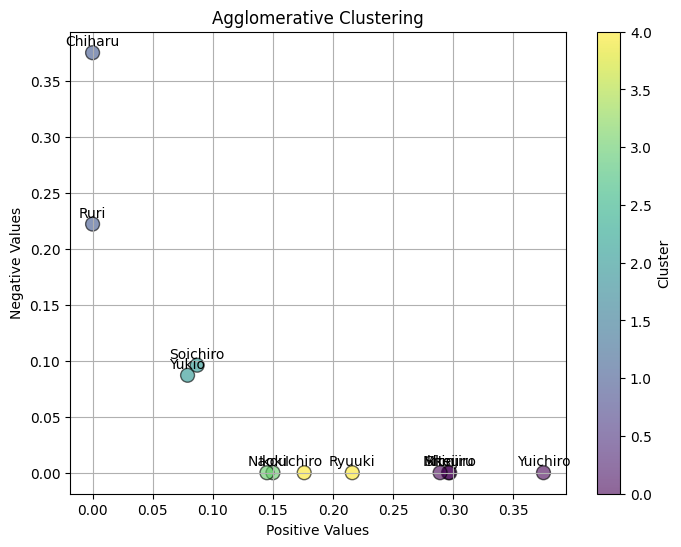

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(df['positive'], df['negative'], c=df['cluster'], s=100, cmap='viridis', edgecolor='k', alpha=0.6)
for i, txt in enumerate(df['name']):
    plt.annotate(txt, (df['positive'][i], df['negative'][i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel('Positive Values')
plt.ylabel('Negative Values')
plt.title('Agglomerative Clustering')
plt.grid(True)
plt.colorbar(label='Cluster')
plt.show()